In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
import numpy as np
import matplotlib.pyplot as plt

import config

sessions = load_and_prepare_sessions("../../../trial_Gq-DREADD_CPT", load_from_pickle=True, remove_bad_signal_sessions=True)

In [2]:
example_session = sessions[0]

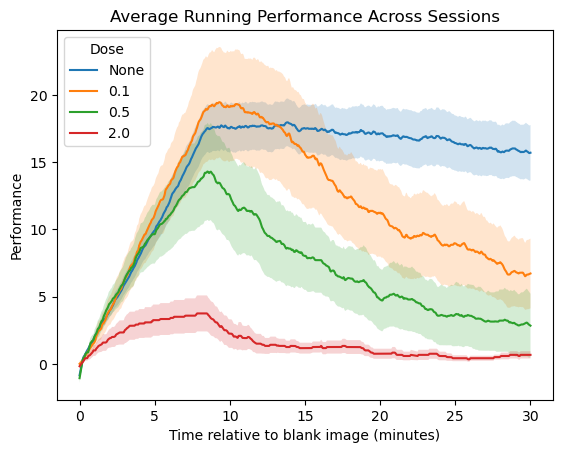

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def running_performance(session, window_time):
    raw_df = session.df_container.data['raw']
    filtered_df = raw_df.loc[session.events_of_interest_df["index"]]
    filtered_df = filtered_df[~filtered_df['Item_Name'].isin(['Display Image'])]

    event_times = filtered_df['SecFromZero_FP3002'].values
    event_names = filtered_df['Item_Name'].values
    blank_image_time = raw_df.iloc[session.cpt]['SecFromZero_FP3002']

    start_time = blank_image_time  # Start at 0 minutes
    end_time = blank_image_time + 30 * 60  # End at 30 minutes

    start_idx = np.searchsorted(event_times, start_time, side='left')
    end_idx = np.searchsorted(event_times, end_time, side='right')

    event_times = event_times[start_idx:end_idx]
    event_names = event_names[start_idx:end_idx]

    events = list(zip(event_times, event_names))
    performance_scores = []

    # Calculate performance for each window
    for i in range(len(events)):
        event_time = events[i][0]

        # Define the start of the time window
        window_start = event_time - window_time

        # Recalculate hits and mistakes within the current window
        hits = sum(1 for etime, etype in events if window_start <= etime <= event_time and etype == 'Hit')
        mistakes = sum(1 for etime, etype in events if window_start <= etime <= event_time and etype == 'Mistake')

        # Calculate the performance score for the current window
        current_performance = hits + mistakes
        performance_scores.append(current_performance)

    return event_times, performance_scores

# Define the common time grid (from 0 to 30 minutes after blank_image_time)
time_start = 0  # Start at 0 minutes
time_end = 30 * 60  # 30 minutes in seconds
common_time_grid = np.linspace(time_start, time_end, 1000)  # Adjust 1000 to the desired granularity

for dose in [None, '0.1', '0.5', '2.0']:
    all_performances = []
    sessions_with_data = 0
    for session in sessions:
        if session.genotype == 'Wildtype':
            continue
        curr_dose = session.drug_info['dose'] 
        if curr_dose != dose:
            continue
        
        event_times, performance = running_performance(session, 500)
        
        if event_times is None or len(event_times) <= 1:
            continue  # Skip sessions with no events in the window

        blank_image_time = session.df_container.data['raw'].iloc[session.cpt]['SecFromZero_FP3002']
        relative_times = event_times - blank_image_time
        
        interpolation_function = interp1d(relative_times, performance, kind='linear', fill_value="extrapolate")
        interpolated_performance = interpolation_function(common_time_grid)
        
        all_performances.append(interpolated_performance)
        sessions_with_data += 1

    if sessions_with_data == 0:
        raise ValueError("No valid performances found across sessions.")

    # Convert list of interpolated performances into a NumPy array for easy manipulation
    all_performances = np.array(all_performances)

    # Calculate the average and SEM across sessions
    average_performance = np.mean(all_performances, axis=0)
    sem_performance = np.std(all_performances, axis=0) / np.sqrt(sessions_with_data)

    # Plot the results
    plt.plot(common_time_grid / 60, average_performance, label=f"{dose}")  # Convert to minutes for x-axis
    plt.fill_between(common_time_grid / 60, average_performance - sem_performance, 
                     average_performance + sem_performance, alpha=0.2)
    
plt.title(f"Average Running Performance Across Sessions")
plt.xlabel("Time relative to blank image (minutes)")
plt.ylabel("Performance")
plt.legend(title="Dose")
plt.show()